# Bonus Point - Multiple Products Gaussian Process In Stochastic Environment

## Assumptions
The demand is stochastic and has some subgaussian noise \
The costs and the prices are values between 0 and 1 \
The demand for each price is a value is between 0 and 1

## Imports
Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

## Demand Function
The demand function returns the number of buyers for product $i_1$ and $i_2$ based on the price $p_1$ of product $i_1$, on the price $p_2$ of product $i_2$ and on the noise. The demand of each product depends on its price, the price of the other product, and some noise.
a, b and c are parameters that regulate the dependency of the demand on each factor.

In [2]:
def demand_function(p1, p2, a=70, b=35, c=0.5):
    noise = np.random.normal(0, 0.05)
    buy_probability_product1 = max(0, 1/(1+np.exp(-(c - a * p1 + b * p2))) + noise)
    buy_probability_product2 = max(0, 1/(1+np.exp(-(c - b * p2 + a * p1))) + noise)
    return buy_probability_product1, buy_probability_product2

## Reward function
Returns the revenue given the demand, the price and the cost of each product.

In [3]:
reward_function = lambda p_1, p_2, n_sales_1, n_sales_2, cost_1, cost_2: (p_1-cost_1)*n_sales_1+(p_2-cost_2)*n_sales_2

# Environment Class
Instantiated taking as input the demand function, the reward function and the costs of the two products
At each round takes in input the prices of the two products and returns the demand of each product and the revenue of the round for the two products

In [4]:
class PricingEnvironment:
    def __init__(self, demand_function, reward_function, cost_1, cost_2):
        self.demand_function = demand_function
        self.reward_function = reward_function
        self.cost_1 = cost_1
        self.cost_2 = cost_2
        self.t = 0
    
    def round(self, p1, p2):
        demand_i1_t, demand_i2_t = demand_function(p1, p2)
        revenue = reward_function(p1, p2, demand_i1_t, demand_i2_t, cost_1, cost_2)
        self.t += 1
        return demand_i1_t, demand_i2_t, revenue

## Gaussian Process
Gaussian Process with a Radial Basis Function Kernel: A regret minimizer for the continuous action set $[0, 1]^2$

In [5]:
# Gaussian process from class (adapted to the 2-dimensional setting)
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, a.shape[-1])
        b_ = b.reshape(-1, b.shape[-1])
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.sum(np.power(a_[i] - b_, 2), axis=1).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x, y = np.array(x), np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1, 1)
            self.x = x
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, self.rbf_kernel(x, x) + self.reg * np.eye(x.shape[0]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)
        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)
        return mu_hat.ravel(), sigma_hat.ravel()

## IGP-UCB Algorithm for 2-dimensional pricing

In [6]:
# IGP-UCB Algorithm
class IGP_UCB:
    def __init__(self, kernel, T, B, R, delta, gamma_func):
        self.kernel = kernel
        self.T = T
        self.B = B
        self.R = R
        self.delta = delta
        self.gamma_func = gamma_func
        self.x = []
        self.y = []
        self.regret = []
        self.gamma = [0]

    def beta_t(self, t):
        gamma_t_minus_1 = self.gamma[-1]
        return self.B + self.R * np.sqrt(2 * (gamma_t_minus_1 + 1 + np.log(1 / self.delta)))

    def run(self):
        for t in range(1, self.T + 1):
            if t == 1:
                p1, p2 = np.random.uniform(0, 1, 2)
            else:
                # Predict mean and variance
                X1 = np.linspace(0, 1, 20)
                X2 = np.linspace(0, 1, 20)
                X_test = np.array([[p1, p2] for p1 in X1 for p2 in X2])
                mu, sigma = self.kernel.predict(X_test)
                ucb = mu + self.beta_t(t) * np.sqrt(sigma)
                p1, p2 = X_test[np.argmax(ucb)]

            # Observe the demand
            demand_i1_t,  demand_i2_t, revenue = env.round(p1, p2)


            # Update the kernel with the new observation
            self.kernel.fit(np.array([[p1, p2]]), np.array([revenue]))

            self.x.append([p1, p2])
            self.y.append(revenue)

            # Calculate regret
            demand_i1_bp, demand_i2_bp = demand_function(best_price[0], best_price[1])
            optimal_revenue = reward_function(best_price[0], best_price[1], demand_i1_bp, demand_i2_bp, cost_1, cost_2)
            self.regret.append(optimal_revenue - revenue)

            # Update gamma
            self.gamma.append(self.gamma_func(self.x, self.y, self.kernel))

### Set parameters
Set some parameters: 
The number of epochs the algorithm is run \
The number of times we run the algorithm \
The parameters of the IGP-UCB algorithms for tuning the bias in the UCB, the noise level and the confidence level

In [7]:
n_epochs = 10
T = 500
B = 0.5
R = 2.0
delta = 0.01

## Gamma function
function to compute the complexity of the gaussian process model

In [8]:
# Define the gamma function
def gamma_func(x, y, kernel):
    # Maximum information gain calculation
    K = kernel.rbf_kernel(np.array(x), np.array(x))
    return 0.5 * np.log(np.linalg.det(np.eye(len(x)) + K))

Set the costs of the products 

In [9]:
cost_1 = 0.2
cost_2 = 0.3

## Clairvoyant
Compute the expected clairvoyant (best fixed couple of prices that optimize the revenue)

In [10]:
# Calculate optimal revenue
prices = np.linspace(0, 1, 100)
profit_curve = np.zeros((len(prices), len(prices)))
for i, p1 in enumerate(prices):
    for j, p2 in enumerate(prices):
        d1, d2 = demand_function(p1, p2)
        profit_curve[i, j] = reward_function(p1, p2, d1, d2, cost_1, cost_2)


best_price_indices = np.unravel_index(np.argmax(profit_curve), profit_curve.shape)
best_price = (prices[best_price_indices[0]], prices[best_price_indices[1]])
optimal_revenue = profit_curve[best_price_indices]
expected_clairvoyant_rewards = np.repeat(optimal_revenue, T)

## Run The algorithm

Run IGP-UCB for the predefined time horizon, calculate the cumulative regret and its standard deviation, and measure the time it takes for it to run.

In [11]:
# Run IGP-UCB for 10 epochs

env = PricingEnvironment(demand_function, reward_function, cost_1, cost_2)

cumulative_regrets = []

start_time = time.time()
for epoch in range(n_epochs):
    np.random.seed(epoch)
    kernel = RBFGaussianProcess(scale=1, reg=1e-2)
    igp_ucb = IGP_UCB(kernel, T, B, R, delta, gamma_func)
    igp_ucb.run()
    cumulative_regrets.append(np.cumsum(igp_ucb.regret))
end_time = time.time()

cumulative_regrets = np.array(cumulative_regrets)
average_cumulative_regret = cumulative_regrets.mean(axis=0)
cumulative_regret_std = cumulative_regrets.std(axis=0)

print(f"Time taken to run {n_epochs} epochs: {end_time - start_time} seconds")

Time taken to run 10 epochs: 114.51272892951965 seconds


## Plot of the cumulative regret
Plot of the cumulative regret of the IGP-UCB with respect to the clairvoyant computed before (in blue)
A square root of T line is represented in orange for a comparison to see if the IGP-UCB algorithm's regret is sublinear

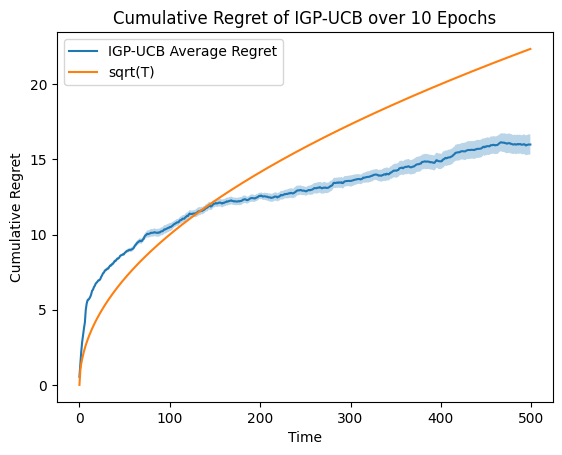

In [12]:
plt.plot(np.arange(T), average_cumulative_regret, label='IGP-UCB Average Regret')
plt.fill_between(np.arange(T),
                 average_cumulative_regret - cumulative_regret_std / np.sqrt(n_epochs),
                 average_cumulative_regret + cumulative_regret_std / np.sqrt(n_epochs),
                 alpha=0.3)

# Add a sublinear comparison line (e.g., sqrt(T))
sqrt_T = np.sqrt(np.arange(T))
plt.plot(np.arange(T), sqrt_T, label='sqrt(T)')

plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret of IGP-UCB over 10 Epochs')
plt.legend()
plt.show()